In [12]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow import keras 
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import glob
import os

In [15]:
from sklearn.datasets import load_files
import numpy as np

train_dir = r'fruits-360_dataset\fruits-360\Training'
test_dir = r'fruits-360_dataset\fruits-360\Test'

def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels
    
x_train, y_train,target_labels = load_dataset(train_dir)
x_test, y_test,_ = load_dataset(test_dir)
print('Loading complete!')

print('Training set size : ' , x_train.shape[0])
print('Testing set size : ', x_test.shape[0])

Loading complete!
Training set size :  67692
Testing set size :  22688


In [ ]:
np.save('target_labels.npy', target_labels)
print('Target labels saved to target_labels.npy')

Target labels saved to target_labels.npy


In [16]:
no_of_classes = len(np.unique(y_train))
no_of_classes

131

In [17]:
from keras.utils import to_categorical
y_train = to_categorical(y_train,no_of_classes)
y_test = to_categorical(y_test,no_of_classes)


In [18]:
from sklearn.model_selection import  train_test_split
x_test,x_valid,y_test,y_valid=train_test_split(x_test,y_test,test_size=0.2,random_state=42)

In [19]:
x_valid.shape, y_valid.shape

((4538,), (4538, 131))

In [20]:
x_test.shape,y_test.shape

((18150,), (18150, 131))

In [21]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img

def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        # Convert to Numpy Array
        images_as_array.append(img_to_array(load_img(file)))
    return images_as_array

x_train = np.array(convert_image_to_array(x_train))
print('Training set shape : ',x_train.shape)

x_valid = np.array(convert_image_to_array(x_valid))
print('Validation set shape : ',x_valid.shape)

x_test = np.array(convert_image_to_array(x_test))
print('Test set shape : ',x_test.shape)

print('1st training image shape ',x_train[0].shape)

Training set shape :  (67692, 100, 100, 3)
Validation set shape :  (4538, 100, 100, 3)
Test set shape :  (18150, 100, 100, 3)
1st training image shape  (100, 100, 3)


In [22]:
x_train = x_train.astype('float32')/255
x_valid = x_valid.astype('float32')/255
x_test = x_test.astype('float32')/255

In [23]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D
from keras.layers import Activation, Dense, Flatten, Dropout,Activation,BatchNormalization
from keras.optimizers import Adamax
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras import backend as K

model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = (3,3),input_shape=(100,100,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32,kernel_size = (3,3),activation = 'relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32,kernel_size = (3,3),activation = 'relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())

model.add(Dense(1024,activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(512,activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(131,activation = 'softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 100, 100, 16)      448       
                                                                 
 activation_1 (Activation)   (None, 100, 100, 16)      0         
                                                                 
 batch_normalization_3 (Bat  (None, 100, 100, 16)      64        
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 50, 50, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 batch_normalization_4 (Bat  (None, 50, 50, 32)       

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot_fruits_2.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [24]:
model.compile(loss='categorical_crossentropy',
              optimizer='Adamax',
              metrics=['accuracy'])

In [30]:
learned_weights = ModelCheckpoint(filepath = 'fruits_360_weights_1.hdf5', verbose = 1, save_best_only = True)

history = model.fit(x_train,y_train,
        batch_size = 50,
        epochs=30,
        validation_data=(x_valid, y_valid),
        callbacks = [learned_weights],
        verbose=2, shuffle=True)

Epoch 1/30



Epoch 1: val_loss improved from inf to 0.28495, saving model to fruits_360_weights_1.hdf5


c:\Users\maras\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1354/1354 - 499s - loss: 1.2508 - accuracy: 0.6855 - val_loss: 0.2850 - val_accuracy: 0.9288 - 499s/epoch - 368ms/step
Epoch 2/30

Epoch 2: val_loss improved from 0.28495 to 0.17057, saving model to fruits_360_weights_1.hdf5
1354/1354 - 434s - loss: 0.1546 - accuracy: 0.9508 - val_loss: 0.1706 - val_accuracy: 0.9672 - 434s/epoch - 321ms/step
Epoch 3/30

Epoch 3: val_loss improved from 0.17057 to 0.15682, saving model to fruits_360_weights_1.hdf5
1354/1354 - 390s - loss: 0.0637 - accuracy: 0.9796 - val_loss: 0.1568 - val_accuracy: 0.9711 - 390s/epoch - 288ms/step
Epoch 4/30

Epoch 4: val_loss improved from 0.15682 to 0.14094, saving model to fruits_360_weights_1.hdf5
1354/1354 - 395s - loss: 0.0394 - accuracy: 0.9876 - val_loss: 0.1409 - val_accuracy: 0.9758 - 395s/epoch - 292ms/step
Epoch 5/30

Epoch 5: val_loss did not improve from 0.14094
1354/1354 - 386s - loss: 0.0258 - accuracy: 0.9918 - val_loss: 0.1549 - val_accuracy: 0.9725 - 386s/epoch - 285ms/step
Epoch 6/30

Epoch 6: val_los

In [25]:
model.load_weights('fruits_360_weights_1.hdf5')

In [26]:
accuracy = model.evaluate(x_test, y_test, verbose=0)
print(accuracy[1])



0.9830853939056396


568/568 [==============================] - 22s 39ms/step


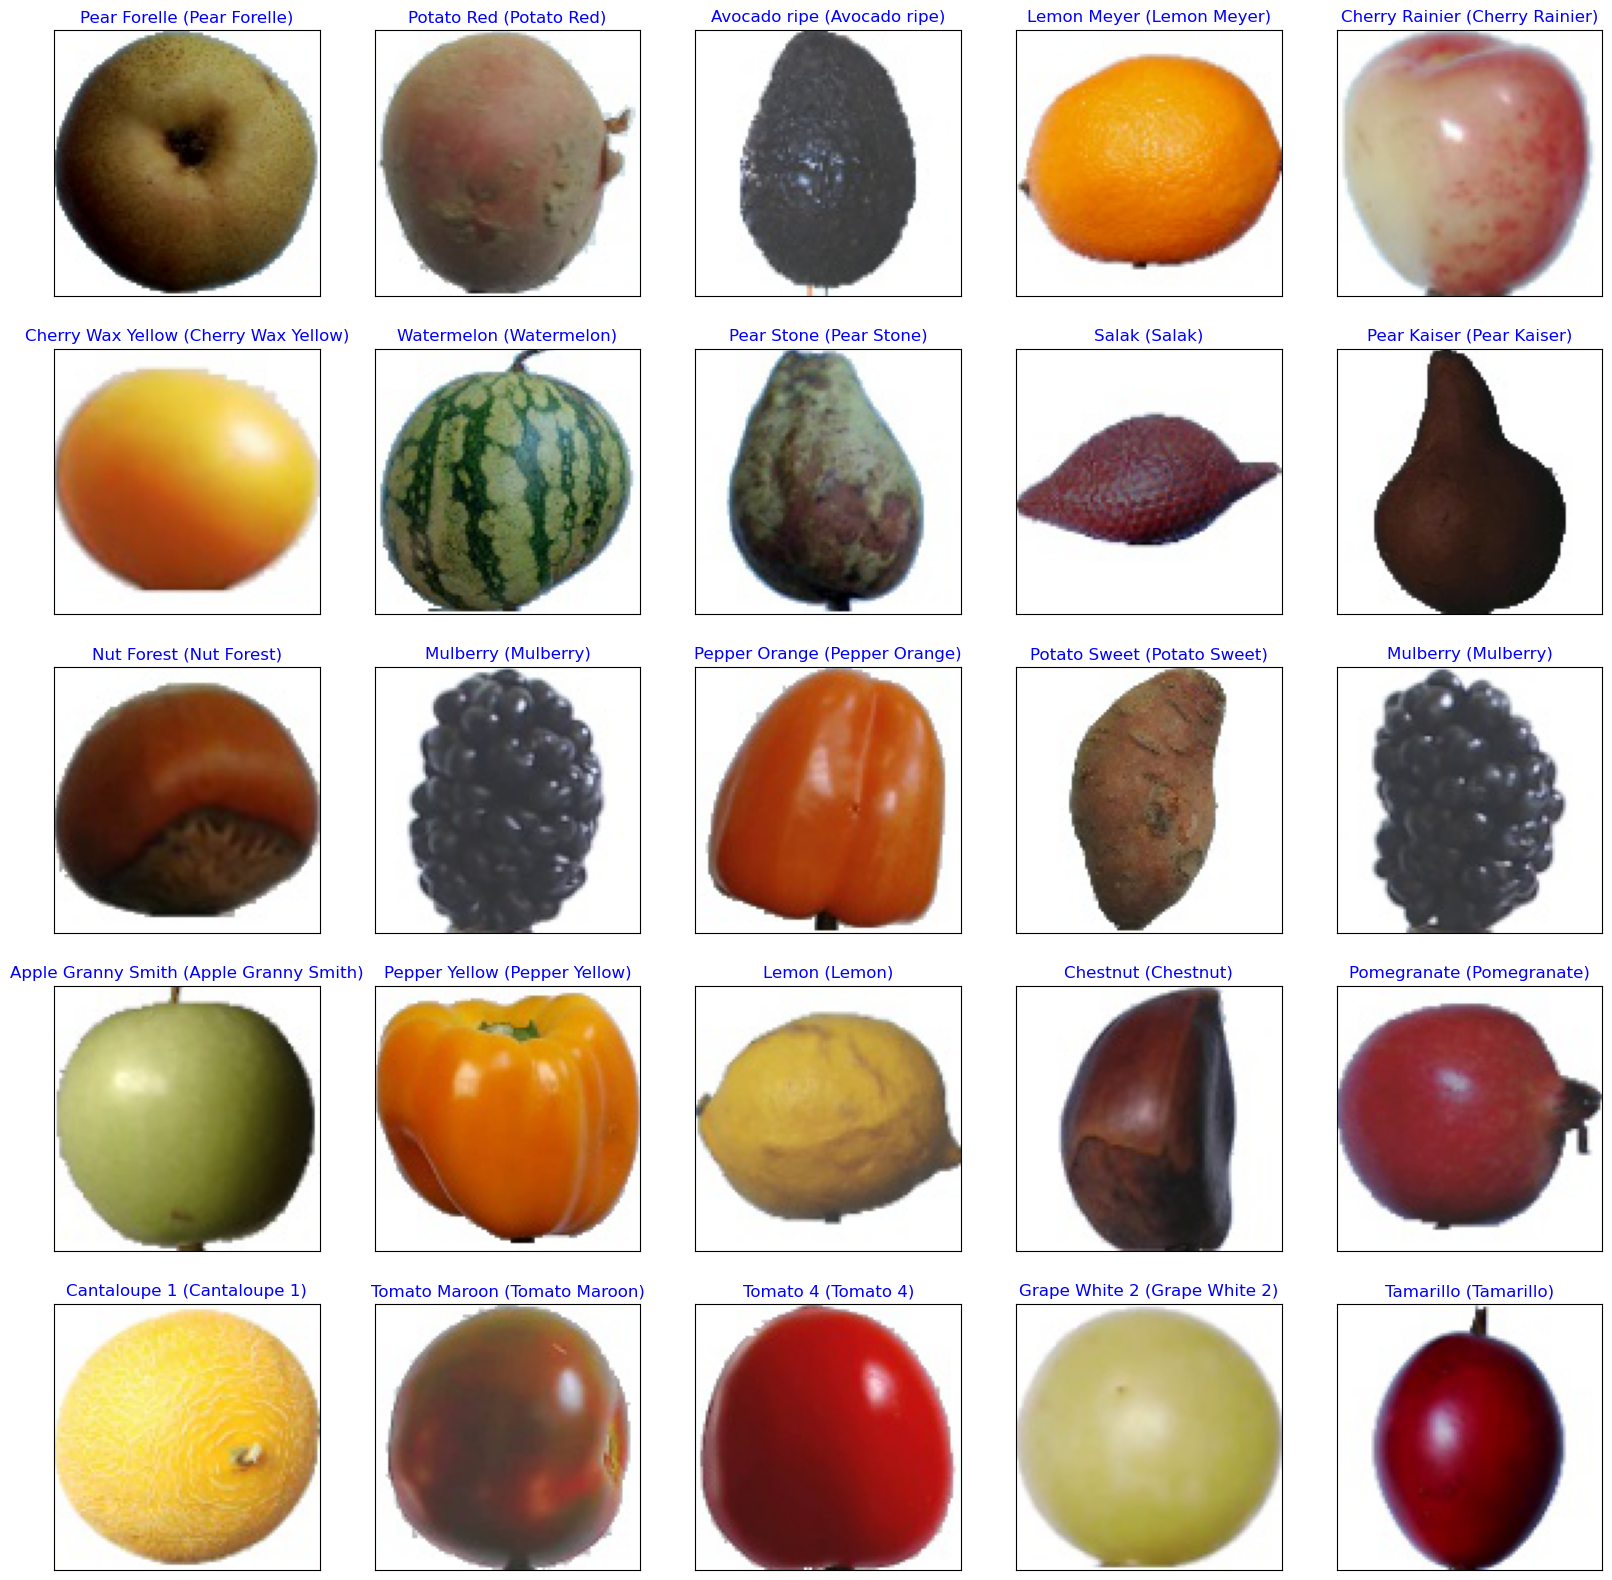

In [28]:
y_pred = model.predict(x_test)

fig = plt.figure(figsize=(20, 20))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=25, replace=False)):
    ax = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "black"))

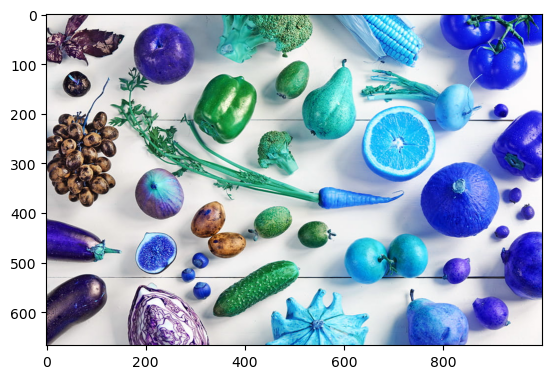

In [14]:
test_img=cv2.imread(r'C:\Users\maras\Downloads\fruit-and-vegetables.jpg')
test_img1=cv2.imread(r'C:\Users\maras\Downloads\fruit-and-vegetables.jpg')
plt.imshow(test_img1)


1/1 [==============================] - 0s 83ms/step
Huckleberry


TypeError: Invalid shape (1, 100, 100, 3) for image data

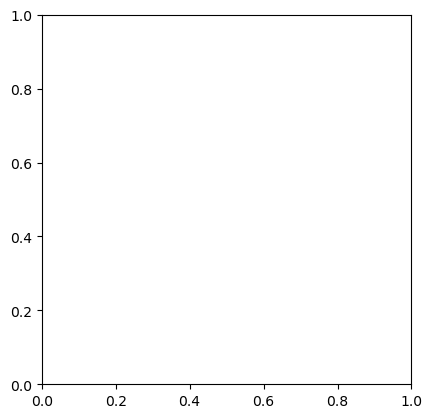

In [18]:
test_img2=cv2.resize(test_img1,(100,100))
test_img2=test_img2.reshape(1,100,100,3)
pred=model.predict(test_img2)
pred=np.argmax(pred)
print(target_labels[pred])
plt.imshow(test_img2)


In [ ]:
"C:\Users\maras\Downloads\20Ounce_NYAS-Apples2.png"

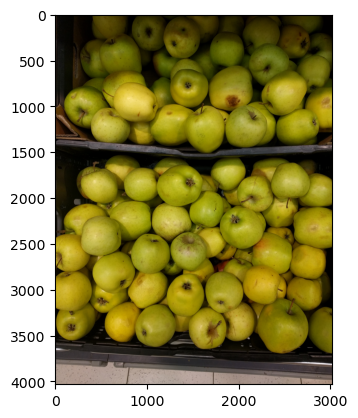

In [21]:
test_apple=cv2.imread(r'D:\Projects\recipereccommendor\fruits-360_dataset\fruits-360\test-multiple_fruits\apple.jpg')
RGB_img = cv2.cvtColor(test_apple, cv2.COLOR_BGR2RGB)
plt.imshow(test_apple)
plt.imshow(RGB_img)

In [22]:
RGB_img=cv2.resize(RGB_img,(100,100))
RGB_img=RGB_img.reshape(1,100,100,3)


In [23]:
pred=model.predict(RGB_img)
pred=np.argmax(pred)
print(target_labels[pred])

1/1 [==============================] - 0s 44ms/step
Cucumber Ripe


In [24]:
test_apple=cv2.resize(test_apple,(100,100))
test_apple=test_apple.reshape(1,100,100,3)

In [30]:
pred=model.predict(test_apple)
pred=np.argmax(pred)
print(target_labels[pred])

1/1 [==============================] - 0s 35ms/step
Huckleberry


In [29]:
image_path = r"D:\Projects\recipereccommendor\fruits-360_dataset\fruits-360\Test\Strawberry\3_100.jpg"
img = cv2.imread(image_path)

In [30]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img
img=img_to_array(img)
img=img.astype('float32')/255
print(img.shape)

(100, 100, 3)


In [31]:
pred=model.predict(img.reshape(1,100,100,3))

1/1 [==============================] - 0s 46ms/step


In [35]:
predicted_class_index = np.argmax(pred)
predicted_class_label = target_labels[predicted_class_index]

In [36]:
print(f"Predicted Class: {predicted_class_label}")

Predicted Class: Huckleberry


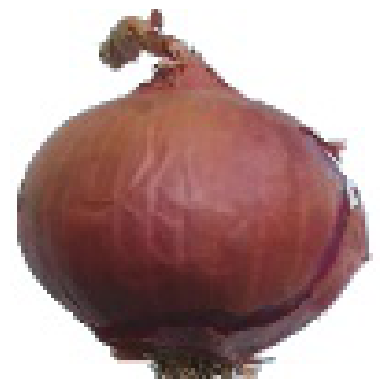

1/1 [==============================] - 0s 104ms/step
Predicted class: Onion Red


In [38]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the image
def load_image(img_path, show=False):
    img = image.load_img(img_path, target_size=(100, 100))
    img_tensor = image.img_to_array(img)  # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)  # (1, height, width, channels), add a dimension because the model expects this shape
    img_tensor /= 255.  # model expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])    
        plt.axis('off')
        plt.show()

    return img_tensor

# Example file path for your image
my_image_path = r'D:\Projects\recipereccommendor\fruits-360_dataset\fruits-360\Test\Onion Red\0_100.jpg'
new_image = load_image(my_image_path, show=True)

# Predict using the model
pred = model.predict(new_image)
predicted_class = np.argmax(pred)

# Display the prediction
print("Predicted class:", target_labels[predicted_class])